<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
df = pd.read_csv("/Users/anand/Documents/Datasets/Quora Question Pair Similarity Problem/train.csv")

In [4]:
df.shape

(404290, 6)

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**Observation**
- id: Looks like a rowId
- qid1/qid2: uniqueId for question 1 & 2 respectively
- question1/2: Questions in text format
- is_duplicate: wheather the tow questions are duplicates of each other 

<h3> 3.2.1 Distribution of data points among output classes </h3>
- Number of duplicate(similar) and non-duplicate(non-similar) questions

In [10]:
df.groupby('is_duplicate')['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

In [11]:
print(type(df.groupby('is_duplicate')['id'].count()))

<class 'pandas.core.series.Series'>


<Axes: xlabel='is_duplicate'>

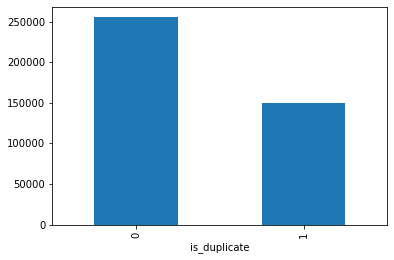

In [12]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [35]:
pd.DataFrame(df.groupby('is_duplicate')['id'].count())

,id
is_duplicate,
0,255027
1,149263


In [36]:
# Number of unique questions
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
unique_qs

537933

In [39]:
np.sum(qids.value_counts()>1)

111780

In [40]:
qs_morethan_onetime = np.sum(qids.value_counts()>1)

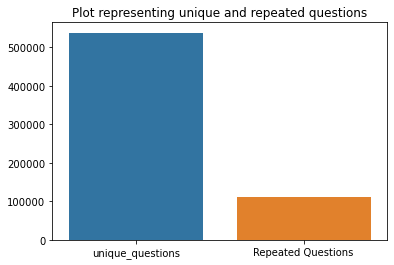

In [45]:
x = ['unique_questions', 'Repeated Questions']
y = [unique_qs, qs_morethan_onetime]

plt.figure()
plt.title('Plot representing unique and repeated questions')
sns.barplot(x=x,y=y)
plt.show()

In [48]:
# Checking for duplicates 
pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
pair_duplicates

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1
...,...,...,...
404285,537924,537925,1
404286,537926,537927,1
404287,537928,537929,1
404288,537930,537931,1


In [49]:
pair_duplicates.shape

(404290, 3)

Text(0, 0.5, 'Number of question')

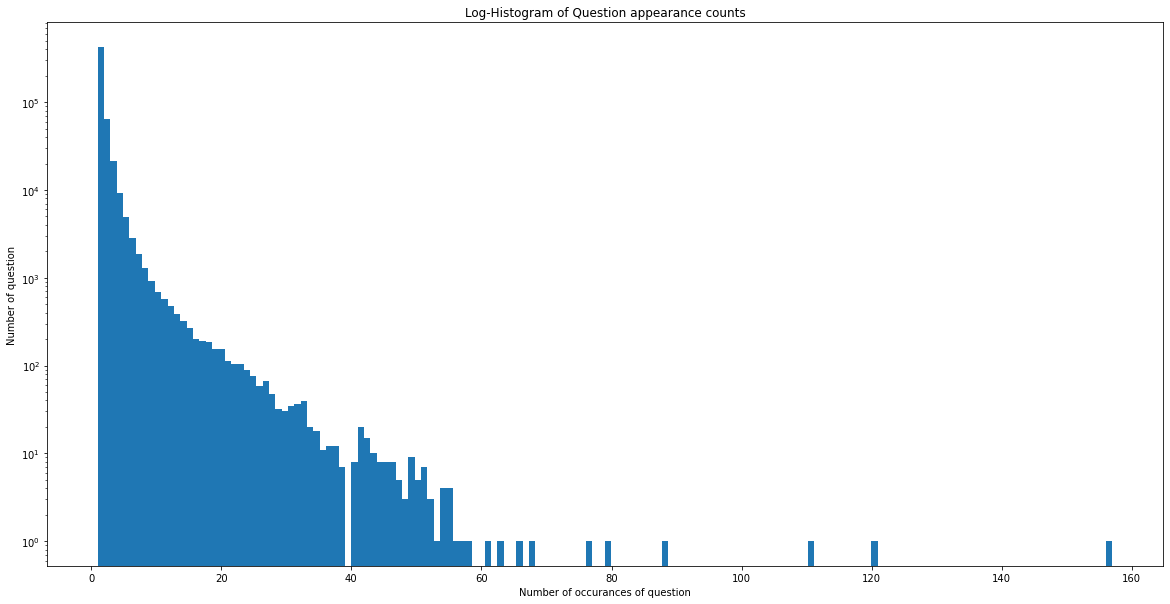

In [54]:
# How many questions occur how many times
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of Question appearance counts')
plt.xlabel('Number of occurances of question')
plt.ylabel('Number of question')

In [53]:
qids.value_counts().max()

157

In [61]:
# Checking the rows with any null values in any column
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [62]:
# Filling the null values with ' '
df = df.fillna('')

In [63]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


## Basic Feature Extraction

- freq_qid1: Frequency of qid1's
- freq_qid2: Frequency of qid2's
- q1len: Length of q1
- q2len: Length of q2
- q1_n_words: Number of words in Question 1
- q2_n_words: Number of words in Question 2
- word_common: number of common unique words in que1 and que2
- word_total: #words in q1 + #words in q2
- word_share = word_common/word_total
- freq_q1+freq_q2: sum total of freq of qid1 and qid2
- freq_q1-freq_q2: absolute difference of frequency of qid1 and qid2

In [64]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [69]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [ ]:
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))
    return 1.0*len(w1 & w2)
df['word_common'] = df.apply(normalized_word_common, axis=1)

In [ ]:
def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))
    return 1.0*(len(w1) + len(w2))
df['word_total'] = df.apply(normalized_word_total, axis=1)

In [ ]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))
    return 1.0*len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [ ]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [106]:
print("Minimum length of the questions in question1: ", min(df['q1_n_words']))
print("Minimum length of the questions in question2: ", min(df['q2_n_words']))

print("Number of questions with minimum length in question1: ", df[df['q1_n_words']==min(df['q1_n_words'])].shape[0])
print("Number of questions with minimum length in question2: ", df[df['q1_n_words']==min(df['q1_n_words'])].shape[0])

Minimum length of the questions in question1:  1
Minimum length of the questions in question2:  1
Number of questions with minimum length in question1:  67
Number of questions with minimum length in question2:  67


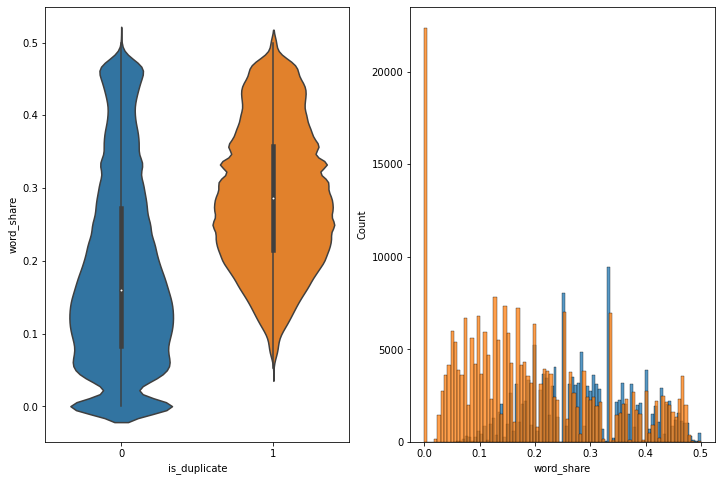

In [112]:
# Feature : Word Share
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1.0]['word_share'][0:], label = "1")
sns.histplot(df[df['is_duplicate']==0.0]['word_share'][0:], label = "0")
plt.show()

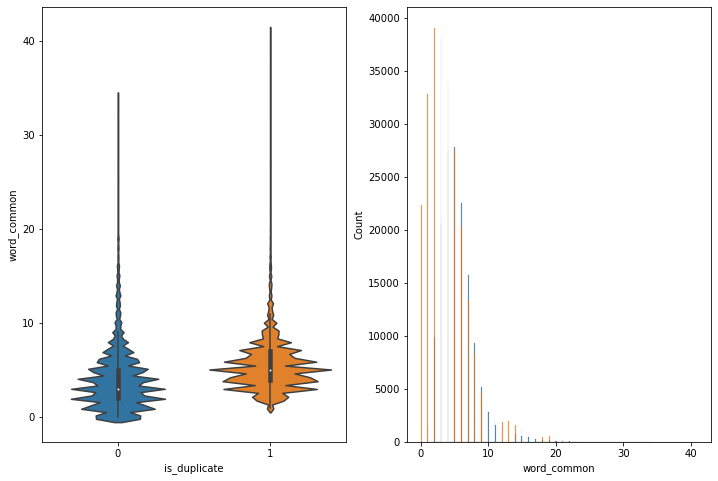

In [113]:
# Feature : Word Common
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1.0]['word_common'][0:], label = "1")
sns.histplot(df[df['is_duplicate']==0.0]['word_common'][0:], label = "0")
plt.show()

## Advanced Feature Extraction

#### Preprocessing of Text
- Removing html tags
- Removing Puntuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [117]:
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [118]:
type('')

str

In [119]:
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

### NLP and Fuzzy Features

**Definition:**
- Token: Get a token by splitting sentence at spaces
- Stop Word: Stop words as per NLTK
- Word: A token that is not a stop word

**Features:**
- cwc_min: Ratio of common word count to min length of word count of Q1 and Q2.<br>
    i.e cwc_min = common_word_count/(min(len(q1_words),len(q2_words))
- cwc_max: Ratio of common word count to max length of word count of Q1 and Q2.<br>
    i.e cwc_max = common_word_count/(max(len(q1_words),len(q2_words))
- csc_min: Ratio of common stop count to min length of stop count of Q1 and Q2.<br>
    i.e csc_min = common_stop_count/(min(len(q1_stops),len(q2_stops))
- csc_max: Ratio of common stop count to max length of stop count of Q1 and Q2.<br>
    i.e csc_min = common_stop_count/(max(len(q1_stops),len(q2_stops))
- ctc_min: Ratio of common token count to min length of token count of Q1 and Q2.<br>
    i.e ctc_min = common_token_count/(min(len(q1_tokens),len(q2_tokens))
- ctc_max: Ratio of common token count to max length of token count of Q1 and Q2.<br>
    i.e ctc_max = common_token_count/(max(len(q1_tokens),len(q2_tokens))
- last_word_eq: Check if the last word of both questions is equal or not <br>
    last_word_eq = int(q1_tokens[-1]==q2_tokens[-1])
- first_word_eq: Check if the first word of both questions is equal or not <br>
    first_word_eq = int(q1_tokens[0]==q2_tokens[0]) 
- abs_len_diff: Abs. length difference <br>
    abs_len_diff = abs(len(q1_tokens)-len(q2_tokens))
- mean_len: Average Token length of both questions <br>
    mean_len = (len(q1_tokens)-len(q2_tokens))/2
- fuzz_ratio
- fuzz_partial_ratio
- token_sort_ratio
- token_set_ratio
- longest_substr_ratio: Ratio of length longest common substring to min length of token count of Q1 and Q2 <br>
    longest_substr_ratio = len(longest common substring)/min(len(q1_tokens),len(q2_tokens))

In [122]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the sentence into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / min(len(q1_words), len(q2_words)+SAFE_DIV)
    token_features[1] = common_word_count / max(len(q1_words), len(q2_words)+SAFE_DIV)
    token_features[2] = common_stop_count / min(len(q1_stops), len(q2_stops)+SAFE_DIV)
    token_features[3] = common_stop_count / max(len(q1_stops), len(q2_stops)+SAFE_DIV)
    token_features[4] = common_token_count / min(len(q1_tokens), len(q2_tokens)+SAFE_DIV)
    token_features[5] = common_token_count / max(len(q1_tokens), len(q2_tokens)+SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1]==q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0]==q2_tokens[0])
    
    # Absolute length difference
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average token length of both Questions
    token_features[9] = (len(q1_tokens)+len(q2_tokens))/2
    
    return token_features

In [123]:
def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0])/(min(len(a), len(b)) + 1)

In [124]:
def extract_features(df):
    # preprocessing each question
    df['question1'] = df["question1"].fillna("").apply(preprocess)
    df['question2'] = df["question2"].fillna("").apply(preprocess)
    
    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))
    
    # Computing Fuzzy Features and Merging with Dataset
    
    print('fuzzy features...')
    
    